In [369]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import random

In [2]:
def f(x):
    return 3 * x * x - 4 * x + 5

In [3]:
f(3.0)

20.0

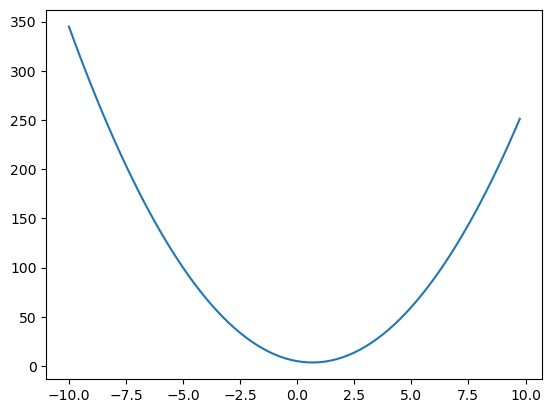

In [4]:
x_values = np.arange(-10, 10, 0.25)
y_values = f(x_values)
plt.plot(x_values, y_values)

In [5]:
h = 0.001
x = 3.0
der = (f(x + h) - f(x)) / h
der

14.00300000000243

In [6]:
# Complex Functions : 
a = 2.0
b = -3.0
c = 10.0
d = a * b + c
d

4.0

In [7]:
h = 0.001
(((a + h) * b + c) - (a * b + c)) / h

-3.0000000000001137

In [211]:
class Value :
    def __init__(self, data, _children = (), _op = '', label = '') :
        self.data = data
        self.grad = 0.0
        self._backward = lambda : None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self) :
        return f"Value (data = {self.data})"

    def __add__ (self, other) :
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        
        return out

    def __mul__ (self, other) :
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out

    def __neg__(self) :
        return self * (-1.0)

    def __sub__(self, other) :
        return self + (-other)

    def __truediv__(self, other) :
        return self * other ** (-1)
    
    def __rmul__(self, other) : # Check if self * other not possible, then do other * self
        return self * other

    def exp(self) :
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')
    
        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward
    
        return out

    def tanh(self) :
        x = self.data
        t = (math.exp(2 * x) - 1) / (math.exp(2 * x) + 1)
        out = Value(t, (self,), label = 'tanh')

        def _backward():
            self.grad = (1 - t**2) * out.grad
        out._backward = _backward
        return out

    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
          if v not in visited:
            visited.add(v)
            for child in v._prev:
              build_topo(child)
            topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
          node._backward()

In [173]:
a = Value(2.0)
b = 3.0
a / b

Value (data = 0.6666666666666666)

In [370]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

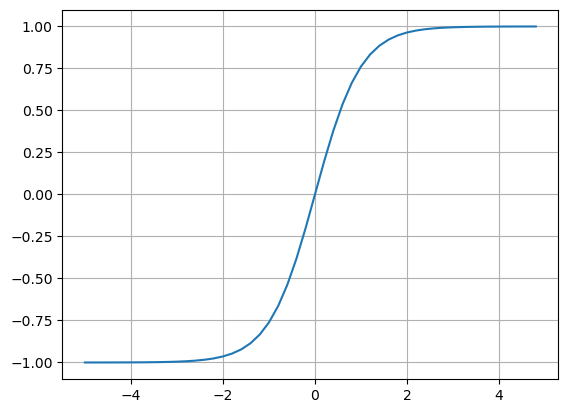

In [14]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

In [109]:
# Simulation of neuron

# Initialise values : 
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')

# Initialise weights :
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')

# Initialise bias :
b = Value(6.8813735870195432, label = 'b')

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'

add = x1w1 + x2w2; add.label = 'Addition'
n = add + b; n.label = 'Neuron'
o = n.tanh(); o.label = 'Output'

In [110]:
o.backward()

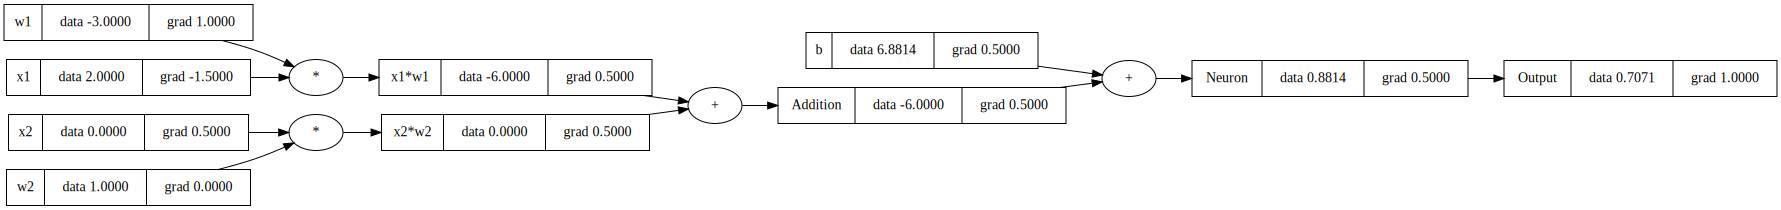

In [111]:
draw_dot(o)

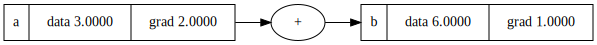

In [113]:
a = Value(3.0, label='a')
b = a + a   ; b.label = 'b'
b.backward()
draw_dot(b)

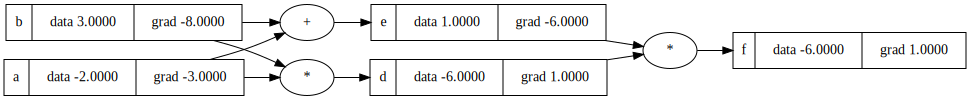

In [116]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b    ; d.label = 'd'
e = a + b    ; e.label = 'e'
f = d * e    ; f.label = 'f'

f.backward()

draw_dot(f)

In [371]:
class Neuron :
    
    def __init__(self, nin) :
        self.w = [Value(random.uniform(-1, 1)) for _ in range (nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__ (self, x) :   
        act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self) :
        return self.w + [self.b]

class Layer :
    
    def __init__(self, nin, nout) :
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x) :
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self) :
        return [p for neuron in self.neurons for p in neuron.parameters()]
        
class MLP :
    
    def __init__(self, nin, nouts) :
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i + 1]) for i in range(len(nouts))]

    def __call__(self, x) :
        for layer in self.layers :
            x = layer(x)
        return x
    
    def parameters(self) :
        return [p for layer in self.layers for p in layer.parameters()]


In [372]:
n = MLP(3, [4, 4, 1])
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [376]:
for epoch in range(20) :
    
    # Forward prop :
    ypred = [n(x) for x in xs]
    loss = sum(((yout - ygt) ** 2 for ygt, yout in zip(ys, ypred)), Value(0.0))
    loss

    # Backward prop :
    for p in n.parameters() : # Note set all grads to zero on every epoch
        p.grad = 0.0
    loss.backward()    

    # Update : 
    for p in n.parameters() :
        p.data += -0.05 * p.grad    

    print(epoch + 1, " - ", loss.data)

1  -  0.0478434424431437
2  -  0.04471032175329146
3  -  0.0419432629756327
4  -  0.03948288694018868
5  -  0.03728186122869698
6  -  0.035302013631339405
7  -  0.033512233590530724
8  -  0.031886922510303554
9  -  0.0304048330547596
10  -  0.029048188504045815
11  -  0.027802006660131977
12  -  0.02665357513344493
13  -  0.025592040027079703
14  -  0.024608080520657712
15  -  0.023693649200728875
16  -  0.02284176319848584
17  -  0.022046334942742926
18  -  0.02130203406033873
19  -  0.020604173957970637
20  -  0.01994861810531684


In [377]:
ypred

[Value (data = 0.9418103076055154),
 Value (data = -0.9325402097923736),
 Value (data = -0.924132703552278),
 Value (data = 0.9209057028654493)]

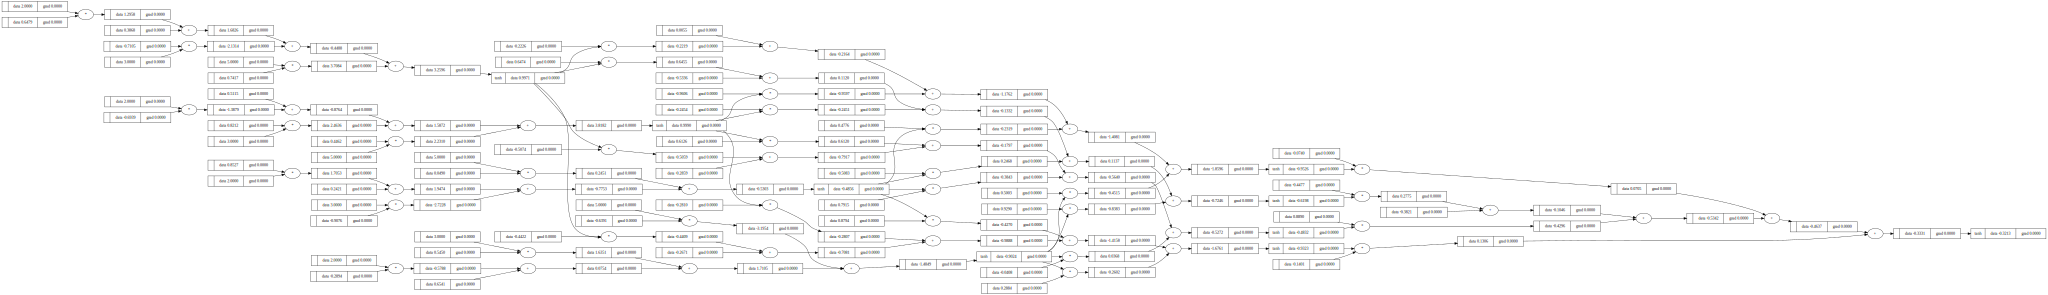

In [251]:
draw_dot(n(x))
draw_dot(loss)

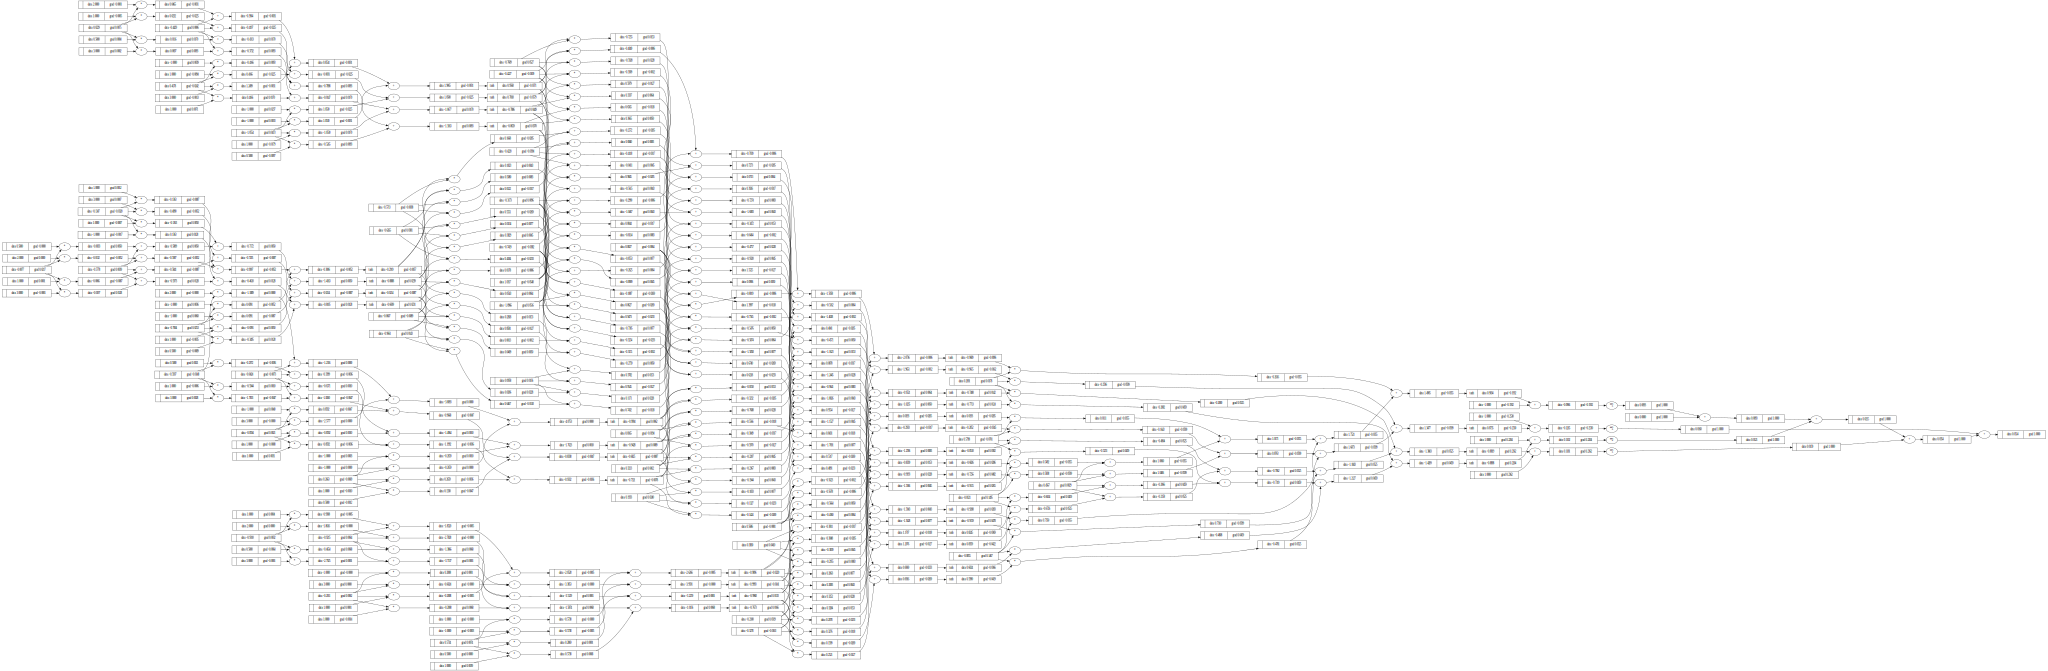

In [375]:
draw_dot(loss)